In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
import warnings
warnings.filterwarnings('ignore')

import re
import jax.numpy as jnp
from jax import grad, jit, partial
import jax
import ticktack
from ticktack import fitting
from tqdm import tqdm
import emcee

import corner
rcParams['figure.figsize'] = (10.0, 5.0)

In [2]:
cbm = ticktack.load_presaved_model('Guttler14', production_rate_units = 'atoms/cm^2/s')
cf = fitting.CarbonFitter(cbm)
cf.load_data('inject_recovery_gp.csv')
cf.prepare_function(use_control_points=True, interp='gp')
cf.offset = 0

In [3]:
params = jnp.array([1.87006282, 1.86604591, 1.86923108, 1.87245341, 1.87024562,
       1.86802098, 1.86881625, 1.86973304, 1.8703945 , 1.87079789,
       1.87086771, 1.870735  , 1.87052202, 1.87033138, 1.87025446,
       1.87034971, 1.87063426, 1.87112396, 1.87183308, 1.87278379,
       1.87400739, 1.87555868, 1.8775013 , 1.87992586, 1.88293838,
       1.88665456, 1.89121002, 1.89674938, 1.9034209 , 1.9113596 ,
       1.92069957, 1.93155953, 1.94402931, 1.9581648 , 1.97396656,
       1.991388  , 2.01032915, 2.03062045, 2.0520171 , 2.07421043,
       2.0968295 , 2.11944471, 2.14158025, 2.16273641, 2.18240006,
       2.20006406, 2.2152569 , 2.2275576 , 2.23661231, 2.24215275,
       2.24402079, 2.24216452, 2.23663562, 2.22759215, 2.21530069,
       2.20012   , 2.18247129, 2.16282158, 2.14167724, 2.11955368,
       2.09694881, 2.0743385 , 2.05215055, 2.03075599, 2.0104651 ,
       1.99151227, 1.97406982, 1.95824811, 1.94409024, 1.93158862,
       1.9206894 , 1.91130913, 1.90333742, 1.896642  , 1.89108806,
       1.88653159, 1.88283411, 1.87986795, 1.87751304, 1.87565992,
       1.87421235, 1.87309169, 1.87223189, 1.87157996, 1.87109172,
       1.87073301, 1.87048262, 1.87032043, 1.87022095, 1.87015584,
       1.87010163, 1.87003322, 1.86992423, 1.86977819, 1.86965124,
       1.86975675, 1.87034489, 1.87096814])

In [4]:
print("total likelihood: ", cf.gp_likelihood(params))
print("gp likelihood: ", cf.gp_neg_log_likelihood(params))
print("chi2: ", cf.loss_chi2(params))

total likelihood:  105.16608938040744
gp likelihood:  105.1660150383358
chi2:  7.43420716437267e-05


In [5]:
initial = params
burnin, production = 500, 1000
ndim, nwalkers = len(initial), 2*len(initial)
sampler = emcee.EnsembleSampler(nwalkers, ndim, cf.gp_sampling_likelihood)

print("Running burn-in...")
p0 = initial + 1e-5 * np.random.rand(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, burnin, progress=True);

Running burn-in...


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [1:08:44<00:00,  8.25s/it]


In [6]:
print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, production, skip_initial_state_check=True, progress=True);

Running production...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [2:16:26<00:00,  8.19s/it]


In [8]:
import pickle
with open('gauss_sampler.p', 'wb') as handle:
    pickle.dump(sampler, handle)

In [9]:
mean = np.mean(sampler.flatchain, axis=0)

In [10]:
mean

array([1.87019215, 1.84513276, 1.90787125, 1.86794884, 1.82670395,
       1.8613062 , 1.91046072, 1.86244555, 1.8528879 , 1.88050179,
       1.87050729, 1.87209226, 1.86096961, 1.91374904, 1.85792175,
       1.84208968, 1.8887727 , 1.88849128, 1.82957413, 1.88291944,
       1.89297948, 1.88964643, 1.91846601, 1.84141347, 1.82947584,
       1.88816746, 1.8451442 , 1.95187361, 1.89699316, 1.89343956,
       1.8998923 , 1.90300578, 2.00595965, 1.93685523, 1.98375064,
       1.9661514 , 2.04343317, 2.03203741, 2.04078188, 2.07730019,
       2.12357701, 2.14531129, 2.14501569, 2.12987951, 2.15711268,
       2.24188425, 2.20437908, 2.24723543, 2.20876869, 2.23298059,
       2.24625634, 2.20717344, 2.25622569, 2.25709878, 2.19946645,
       2.17703732, 2.15365303, 2.16745693, 2.17914759, 2.11087519,
       2.13588272, 2.08060057, 2.02150212, 1.98582023, 1.96872945,
       2.04037264, 2.00627014, 1.93746722, 1.94184304, 1.92527213,
       1.94395907, 1.92888737, 1.86027771, 1.87813368, 1.96369

In [11]:
std = np.std(sampler.flatchain, axis=0)

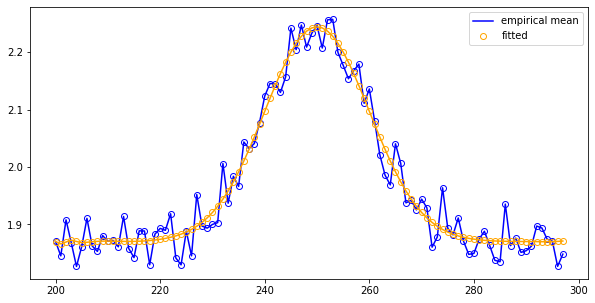

In [12]:
d14c = cf.dc14(params=mean)
d14c_fine = cf.dc14_fine(params=mean)
plt.plot(cf.control_points_time, mean, "bo", fillstyle="none")
plt.plot(cf.control_points_time, mean, color="b", label="empirical mean")
plt.plot(cf.control_points_time, params, 'o', color="orange", fillstyle="none", label="fitted")
plt.plot(cf.control_points_time, params, color="orange")
plt.legend()

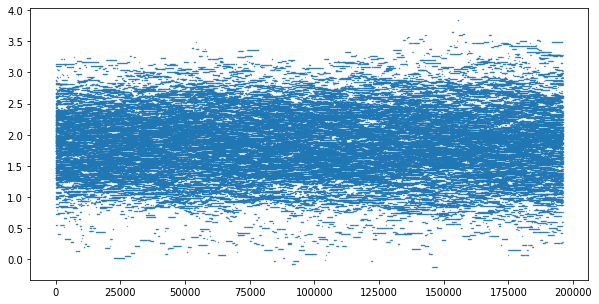

In [13]:
plt.plot(sampler.flatchain[:, 7], ".", markersize=0.6)

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.94it/s]


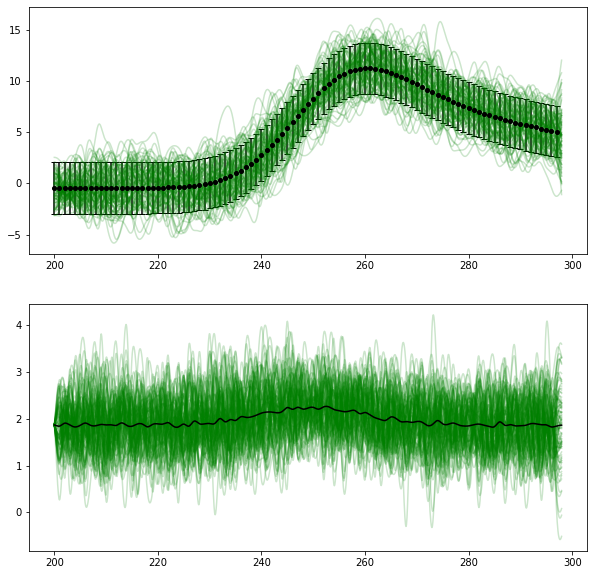

In [14]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))
n = 100
top_n = np.random.permutation(len(sampler.flatchain))[:n]
ax1.errorbar(cf.time_data[:-1], cf.d14c_data[:-1], yerr=cf.d14c_data_error[:-1], 
             fmt="o", color="k", fillstyle="full", capsize=3, markersize=4)
for i in tqdm(top_n):
    d14c = cf.dc14_fine(params=sampler.flatchain[i, :])
    ax1.plot(cf.time_grid_fine, d14c, color="g", alpha=0.2)
    control_points_fine = cf.production(cf.time_grid_fine, (sampler.flatchain[i, :],))
    ax2.plot(cf.time_grid_fine, control_points_fine, color="g", alpha=0.2)
control_points_fine = cf.production(cf.time_grid_fine, (mean,))
ax2.plot(cf.time_grid_fine, control_points_fine, "k")

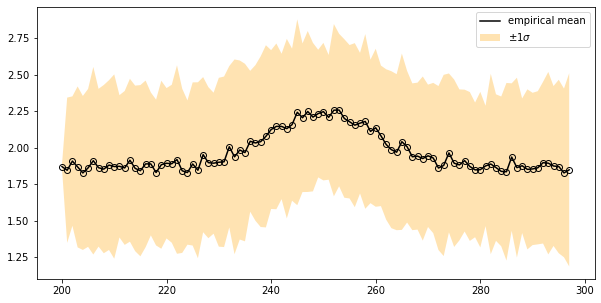

In [15]:
std = np.std(sampler.flatchain, axis=0)
plt.fill_between(cf.control_points_time, mean+std, mean-std, 
                 color='orange', alpha=0.3, edgecolor='none', label='$\pm 1\sigma$')
plt.plot(cf.control_points_time, mean, color="k", label="empirical mean")
plt.plot(cf.control_points_time, mean, "ko", fillstyle="none")
plt.legend()

In [19]:
std

array([0.00882834, 0.49711494, 0.44289634, 0.55060162, 0.52682166,
       0.54038136, 0.64182269, 0.53982484, 0.57559453, 0.58082214,
       0.63054635, 0.48691799, 0.52654206, 0.55730004, 0.56636665,
       0.5858325 , 0.57023845, 0.48899479, 0.49886625, 0.57475158,
       0.51454069, 0.54025445, 0.64486217, 0.56189362, 0.49363327,
       0.5581692 , 0.60195126, 0.53075523, 0.51693592, 0.48246971,
       0.57770532, 0.58347885, 0.55204297, 0.66642649, 0.61260131,
       0.60749848, 0.48206176, 0.53243563, 0.58402552, 0.62337397,
       0.54340231, 0.56707322, 0.49756732, 0.61421583, 0.52051167,
       0.63579576, 0.50859898, 0.55070045, 0.50808976, 0.4367564 ,
       0.47060574, 0.42675314, 0.58929593, 0.52176887, 0.54233187,
       0.5249745 , 0.5613062 , 0.48129121, 0.59774291, 0.49098259,
       0.54056494, 0.48082625, 0.51462013, 0.53705728, 0.53389018,
       0.6032882 , 0.51889537, 0.50222803, 0.50283195, 0.56143688,
       0.48706585, 0.51420676, 0.56112505, 0.62012593, 0.54371

In [17]:
sample = sampler.flatchain[:, :10]

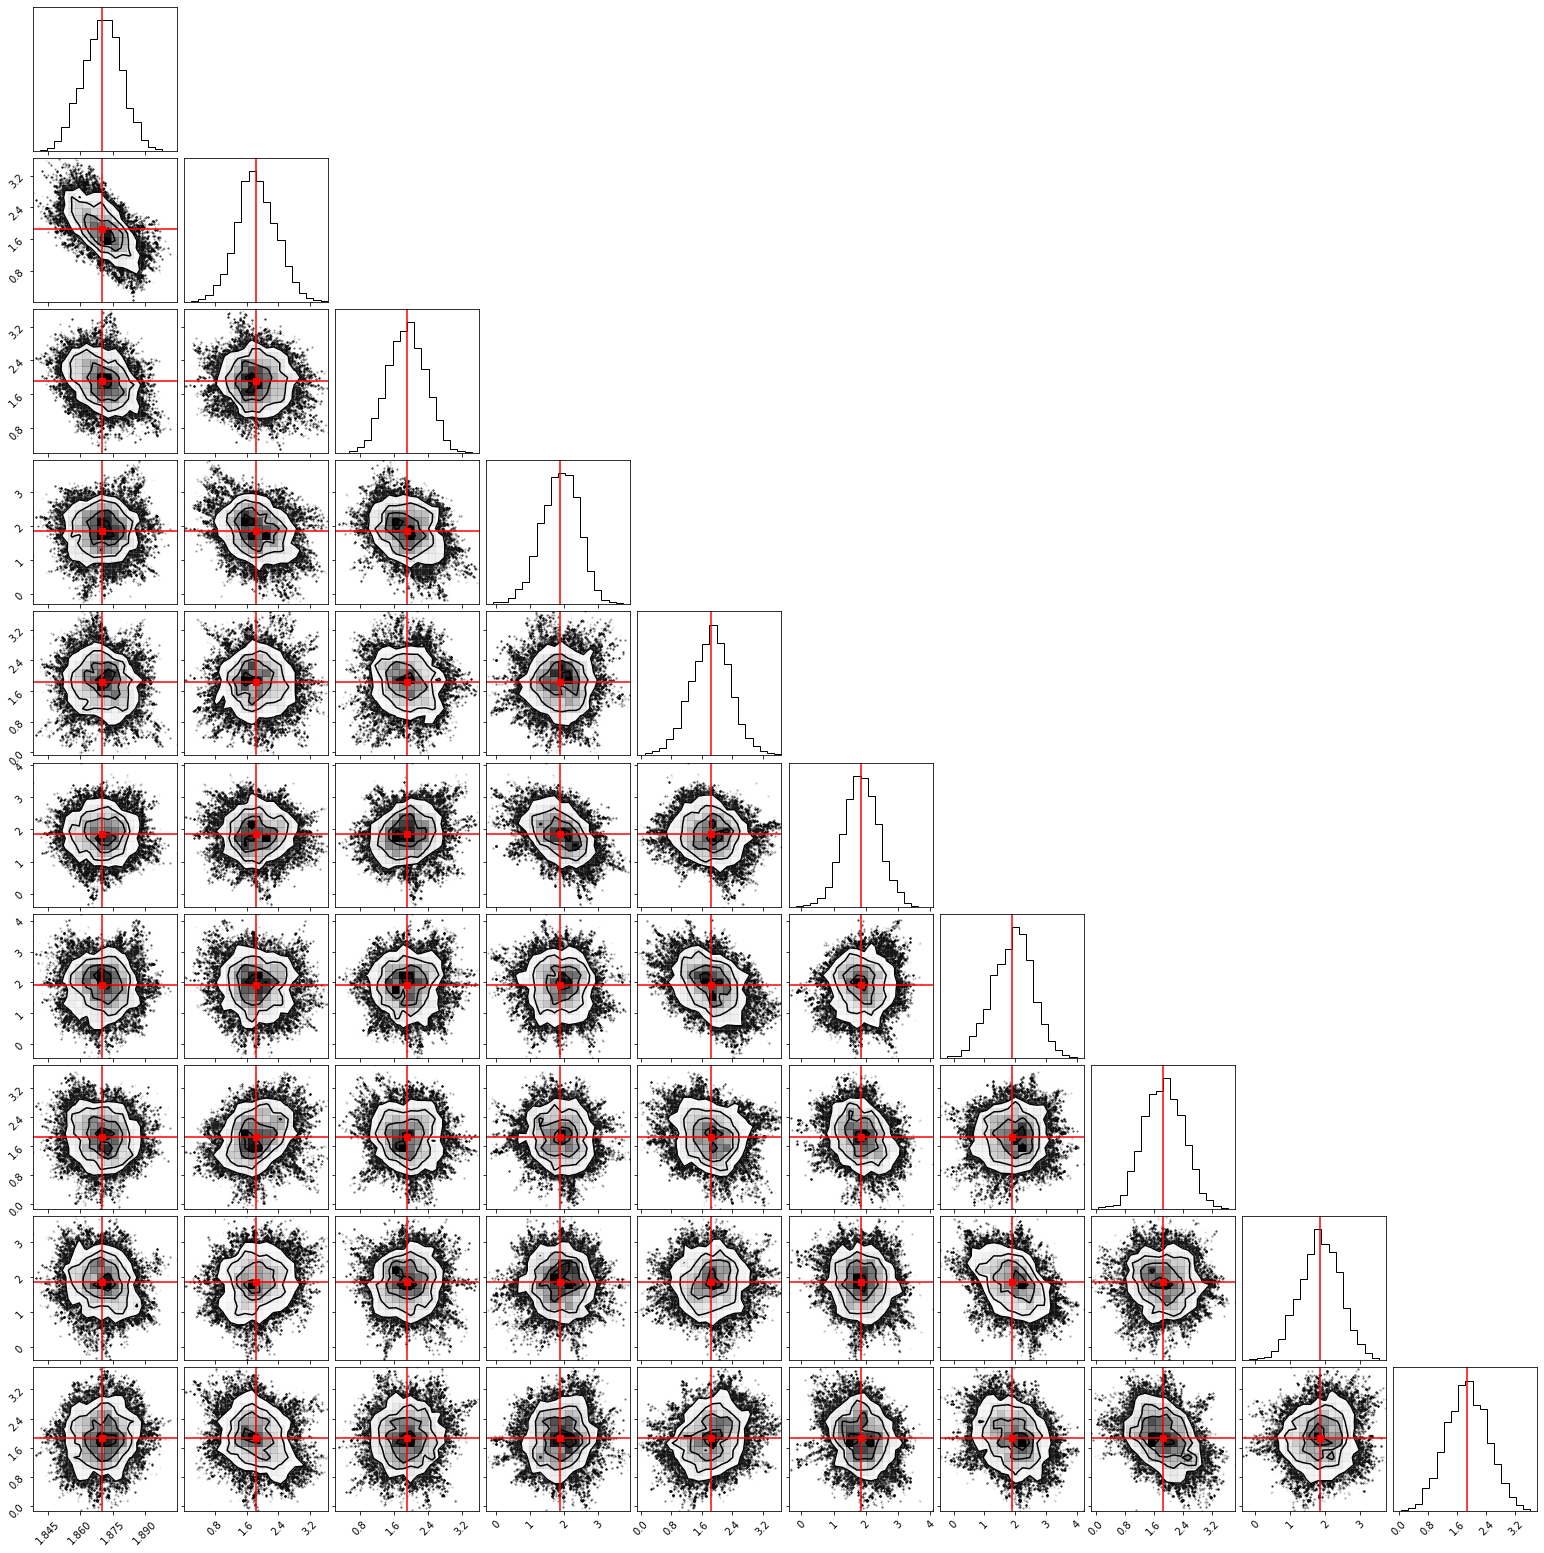

In [20]:
ndim = sample.shape[1]
figure = corner.corner(sample)
value = np.mean(sample, axis=0)
axes = np.array(figure.axes).reshape((ndim, ndim))
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(value[i], color="r")

for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(value[xi], color="r")
        ax.axhline(value[yi], color="r")
        ax.plot(value[xi], value[yi], "sr")